# Definimos el problema

Queremos establecer el alamacen de nuestra empresa en otra localizacion y necesitamos estimar el ritmo de las ventas, que desde la creacion de la empresa ha ido en aumento, para los proximo meses, a fin de proveer el espacion que necesitaremos.

## Paso 1 (Cargar el conjunto de datos)

In [2]:
# Librerias
import pandas as pd

In [3]:
# Leemos los datos
data = pd.read_csv('../data/raw/sales.csv')
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [4]:
# Tansformar fecha a objeto Datetime
data['date'] = pd.to_datetime(data.date)

# Establecer la columna `date` como el indice del dataframe
data = data.set_index('date')

# Extraer la columna `sales` y crear una serie temporal
ts = data['sales']

ts.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

### Trazamos la linea temporal

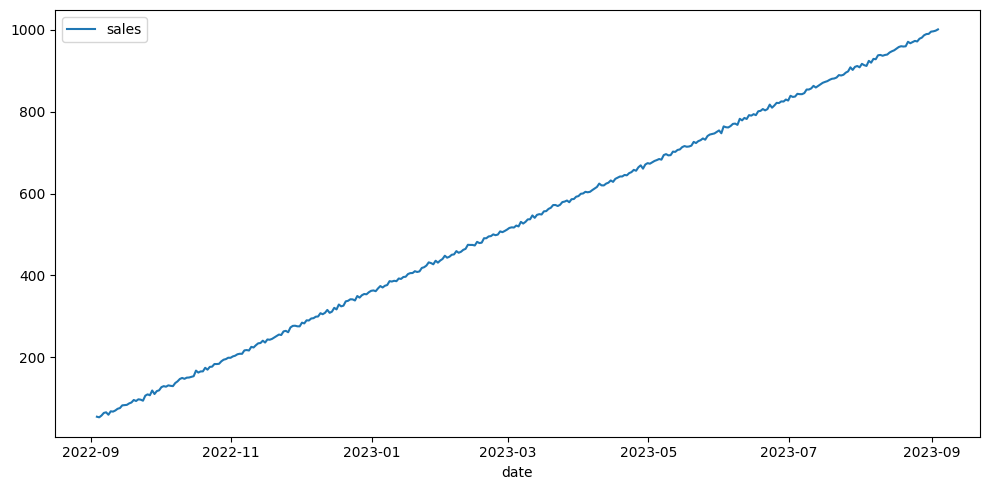

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data)

plt.tight_layout()
plt.show()

## Paso 2 (Construir y analizar la serie temporal)

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
  print('Dickey-Fuller test results: ')
  dftest = adfuller(timeseries, autolag = 'AIC')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  return dfoutput

In [7]:
test_stationary(ts)

Dickey-Fuller test results: 


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

### Descomposicion de la serie

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposition = seasonal_decompose(ts)
descomposition

### Analisis de tendencias

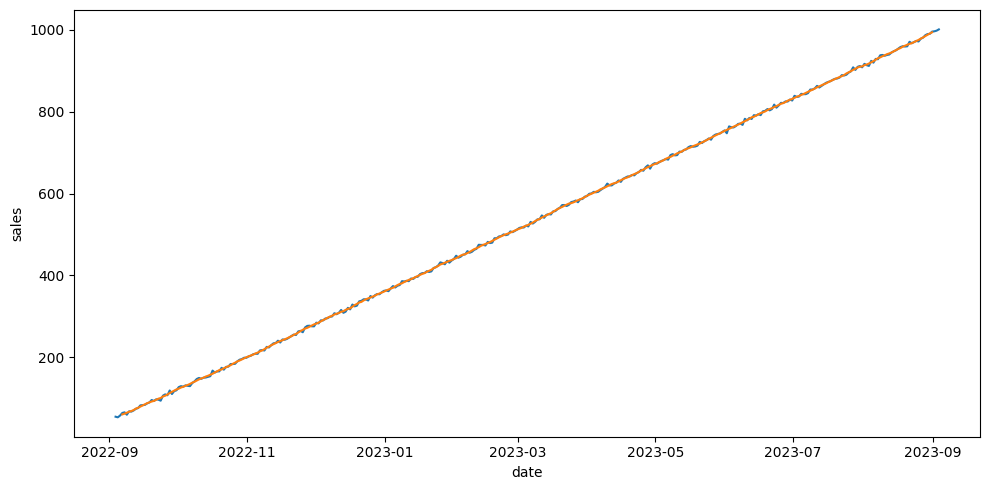

In [9]:
tendencia = descomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(tendencia)

plt.tight_layout()
plt.show()

Puedo ver que a media que pasan las fecha aumenta la tendencia.

### Analisis de la estacionalidad

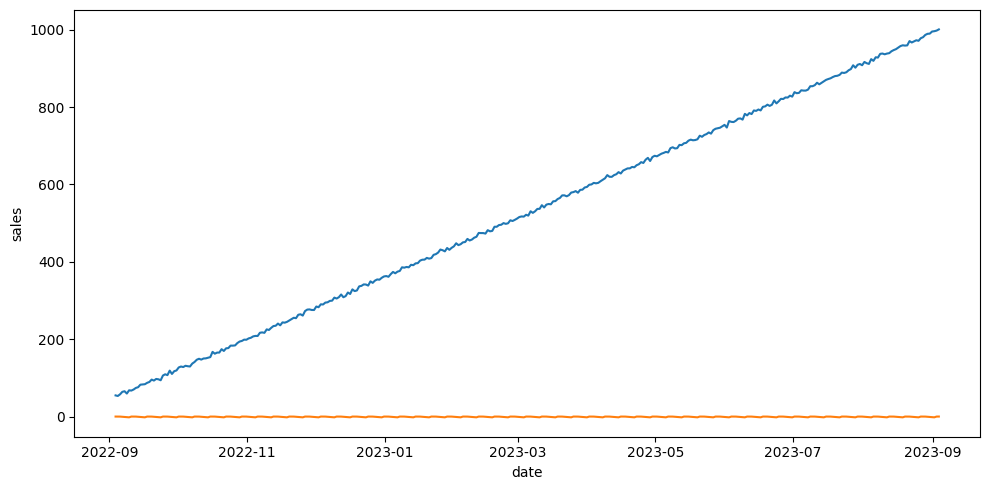

In [10]:
estacionalidad = descomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = estacionalidad)

plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
  df_test = adfuller(timeseries, autolag = 'AIC')
  
  df_output = {
    'Tests Statistics' : df_test[0],
    'p-value' : df_test[1],
    '#Lags Used' : df_test[2],
    'Number of Observations Used' : df_test[3]
  }
  
  df_output.update({
    f'Critical Value ({key})' : value for key, value in df_test[4].items()
  })
  return df_output

test_stationary(ts)

{'Tests Statistics': 0.545414193706381,
 'p-value': 0.9861899815311065,
 '#Lags Used': 13,
 'Number of Observations Used': 352,
 'Critical Value (1%)': -3.4490648539347544,
 'Critical Value (5%)': -2.8697861692116478,
 'Critical Value (10%)': -2.5711631253228306}

### Analisis de Variabilidad

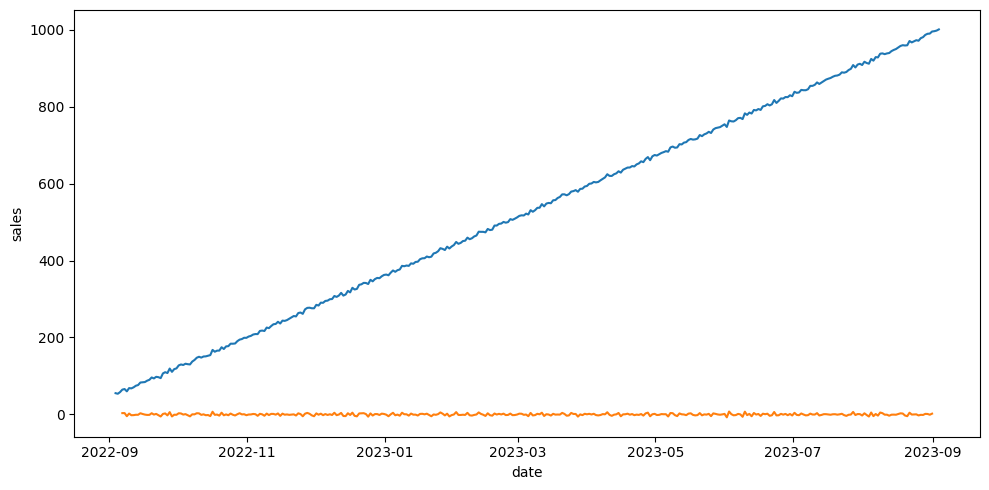

In [12]:
residual = descomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()
plt.show()

### Analisis de correlacion

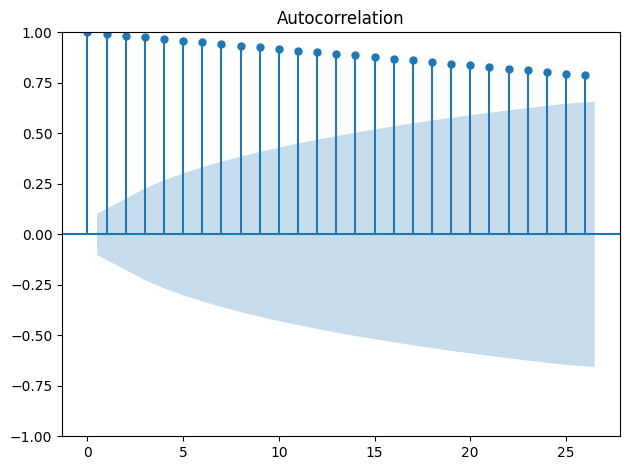

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()
plt.show()

## Paso 3 (Entrenar un ARIMA)

In [14]:
from pmdarima import auto_arima

model = auto_arima(ts, seasonal = False, trace = True, m = 7)

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.380 seconds


## Paso 4 (Predecir con el conjunto de prueba)

In [15]:
forecast = model.predict(60)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831668
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217253
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
2023-09-14 17:10:08.079328    1028.206408
2023-09-15 17:10:08.079328    1030.804239
2023-09-16 17:10:08.079328    1033.402071
2023-09-17 17:10:08.079328    1035.999902
2023-09-18 17:10:08.079328    1038.597733
2023-09-19 17:10:08.079328    1041.195564
2023-09-20 17:10:08.079328    1043.793395
2023-09-21 17:10:08.079328    1046.391226
2023-09-22 17:10:08.079328    1048.989057
2023-09-23 17:10:08.079328    1051.586888
2023-09-24 17:10:08.079328    1054.184719
2023-09-25 17:10:08.079328    1056.782550
2023-09-26 17:10:08.079328    1059.380381
2023-09-27 17:10:08.079328    1061

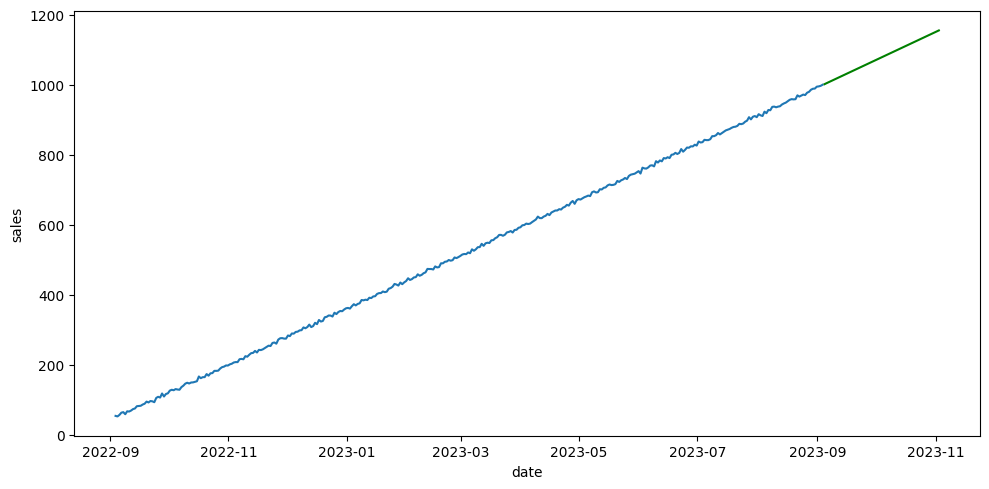

In [16]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = 'green')

plt.tight_layout()
plt.show()

## Paso 5 (Almacenamos el modelo)

In [18]:
from pickle import dump

# model = auto_arima(ts, seasonal = False, trace = True, m = 7)
dump(model, open('../models/arima_ts_seasonal-False_trace-True_m-7.sav', 'wb'))